# Introduction
## Introduction

In this project you will:
1. Learn how to build a **custom Gymnasium environment** simulating a router packet scheduler.
2. Apply **Q-learning** to train an RL agent to schedule packets efficiently across different traffic types.

---

`RouterSchedulingEnv` is a custom environment where a router handles packets from three queues — **Video**, **Voice**, and **Data**. Each type of traffic has different latency sensitivities:

- **Video:** Must be delivered within 6 time units  
- **Voice:** Must be delivered within 4 time units  
- **Data:** Best-effort (no strict deadline)

At each time step, packets arrive probabilistically to each queue, and the agent must select a queue to serve in order to maximize successful, timely packet delivery and minimize deadline violations.

---

## Problem Definition

> **Objective:** Minimize deadline violations and packet delay while maximizing timely delivery.  
> **State:** `[video_queue_len, voice_queue_len, data_queue_len]` (and optionally current queue for scenario 2)  
> **Action:**  
> - **Scenario 1:** `0 = serve video`, `1 = serve voice`, `2 = serve data`  
> - **Scenario 2:** `0 = switch queue`, `1 = serve current queue` (with switching costing 1 timestep)  
> **Reward:**  
> - `+1` for serving within deadline  
> - `-10` for missing deadline  
> - `-1` for serving empty queue or switching unnecessarily  

---

## Why Gymnasium?

> OpenAI Gym has been deprecated and handed over to the Farama Foundation.  
> Gymnasium is its successor, actively maintained and compatible with new APIs.  
> It supports custom environments like `RouterSchedulingEnv` for real-world inspired RL tasks.

---


In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import time


In [3]:
def discretize_state(state):
    # State is already discrete (queue lengths), just convert to tuple
    return tuple(state)


In [4]:
# Max queue length (assumed 10 from env)
max_len = 10
num_actions = 3  # serve video, voice, or data

# Q-table: shape = (video_len, voice_len, data_len, action)
Q = np.random.uniform(low=-1, high=1, size=(max_len+1, max_len+1, max_len+1, num_actions))


In [5]:
learning_rate = 0.1
discount = 0.95
epsilon = 0.8
min_epsilon = 0.01
episodes = 5000
epsilon_decay = (epsilon - min_epsilon) / episodes


In [13]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class RouterSchedulingEnv(gym.Env):
    def __init__(self):
        super(RouterSchedulingEnv, self).__init__()
        
        self.num_queues = 3
        self.max_queue_length = 10
        self.delay_thresholds = [6, 4, np.inf]

        self.observation_space = spaces.MultiDiscrete([self.max_queue_length + 1] * self.num_queues)
        self.action_space = spaces.Discrete(self.num_queues)

        self.queues = [[] for _ in range(self.num_queues)]
        self.timestep = 0

    def reset(self, seed=None, options=None):
        self.queues = [[] for _ in range(self.num_queues)]
        self.timestep = 0
        return self._get_obs(), {}

    def step(self, action):
        self.timestep += 1

        # Random arrivals
        arrivals = [np.random.rand() < p for p in [0.3, 0.25, 0.4]]
        for i in range(self.num_queues):
            if arrivals[i] and len(self.queues[i]) < self.max_queue_length:
                self.queues[i].append(0)

        # Age packets
        for q in self.queues:
            for i in range(len(q)):
                q[i] += 1

        # Serve packet
        reward = 0
        if self.queues[action]:
            delay = self.queues[action].pop(0)
            deadline = self.delay_thresholds[action]
            reward = 1 if delay <= deadline else -10
        else:
            reward = -1

        done = False
        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        return np.array([len(q) for q in self.queues], dtype=int)

    def render(self):
        print(f"Timestep {self.timestep} | Queues: {[len(q) for q in self.queues]}")


In [15]:
env = RouterSchedulingEnv()


In [ ]:
reward_list = []

for ep in range(episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state)
    total_reward = 0
    done = False

    for step in range(100):  # fixed episode length
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q[state_disc])

        next_state, reward, _, _, _ = env.step(action)
        next_state_disc = discretize_state(next_state)

        # Q-learning update
        Q[state_disc + (action,)] = (1 - learning_rate) * Q[state_disc + (action,)] + \
            learning_rate * (reward + discount * np.max(Q[next_state_disc]))

        state_disc = next_state_disc
        total_reward += reward

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay)
    reward_list.append(total_reward)

    # Track progress
    if (ep + 1) % 500 == 0:
        print(f"Episode {ep+1} | Avg Reward (last 100): {np.mean(reward_list[-100:]):.2f}")


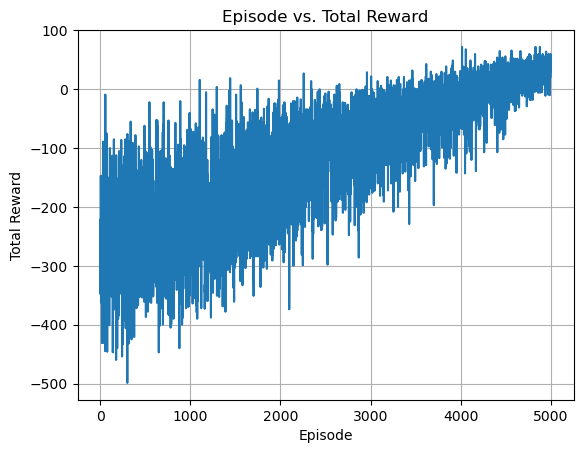

In [17]:
plt.plot(reward_list)
plt.title("Episode vs. Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [20]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Run the policy and capture queue states as frames
state, _ = env.reset()
state_disc = discretize_state(state)

frames = []
actions = []

for t in range(30):  # simulate for 30 time steps
    action = np.argmax(Q[state_disc])
    next_state, reward, _, _, _ = env.step(action)
    next_state_disc = discretize_state(next_state)

    # Capture snapshot
    frame = {
        "step": t,
        "state": state.copy(),
        "action": action,
        "reward": reward
    }
    frames.append(frame)

    state = next_state
    state_disc = next_state_disc

# Plotting setup
fig, ax = plt.subplots(figsize=(6, 4))

def update(i):
    ax.clear()
    frame = frames[i]
    bars = ax.bar(["Video", "Voice", "Data"], frame["state"], color=["red", "orange", "blue"])
    ax.set_ylim(0, env.max_queue_length)
    ax.set_title(f"Step {frame['step'] + 1} | Action: Queue {frame['action']} | Reward: {frame['reward']}")
    ax.set_ylabel("Queue Length")
    return bars

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=500, blit=False)
plt.close(fig)  # prevent showing static image

HTML(ani.to_jshtml())
